In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from IPython import display

In [13]:
import matplotlib.animation as animation

## define setting

In [2]:
function = lambda x : x

In [3]:
value_low = -5
value_high = 5

In [73]:
x = np.linspace(-5,5, 1000)

In [5]:
batchsize = 256

The train loop: we'll reuse this, so lets define it here

In [6]:
def train_loop(train_steps, network):
    for _ in range(train_steps):
        batch = np.random.rand(batchsize,1) * (value_high-value_low) + value_low
        targets = function(batch)
        batch = torch.tensor(batch, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)
        predictions = network(batch)
        
        
        loss_value = loss(targets, predictions)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

## start simple: Linear

In [22]:
lin_net = torch.nn.Sequential(torch.nn.Linear(1,1)) 

In [23]:
optimizer = torch.optim.SGD(lin_net.parameters(), lr = 0.01)

In [9]:
loss = torch.nn.MSELoss()

In [10]:
x_torch = torch.tensor(x.reshape(-1,1), dtype=torch.float32)

In [11]:
lin_net.modules()

<generator object Module.modules at 0x000001A63E2CC518>

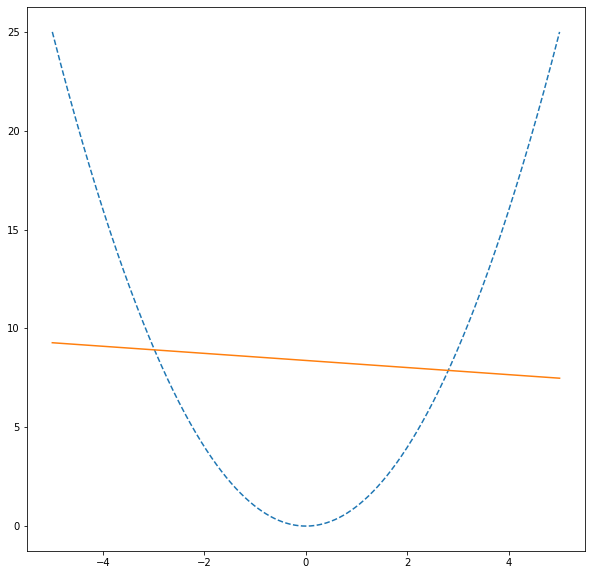

In [15]:
fig, axs = plt.subplots(1, figsize=(10,10))
#true function
axs.plot(x, function(x), linestyle="dashed")
#first aproximation random weights
y = lin_net(x_torch).detach().numpy().squeeze()
line, = axs.plot(x,y)

def animate(i):    
    train_loop(10,lin_net)
    y = lin_net(x_torch).detach().numpy().squeeze()
    line.set_ydata(y)
    
    return line,

ani = animation.FuncAnimation(fig, animate, repeat=False, frames = 100,
                                    interval=10, blit=True, save_count=3)
writergif = animation.PillowWriter(fps=30)
ani.save('linonelayer.gif',writer=writergif)

In [165]:
#add relu
relu_net = torch.nn.Sequential(torch.nn.Linear(1,1),torch.nn.ReLU()) 
optimizer = torch.optim.SGD(relu_net.parameters(), lr = 0.01)
loss = torch.nn.MSELoss()

AttributeError: 'list' object has no attribute 'set_ydata'

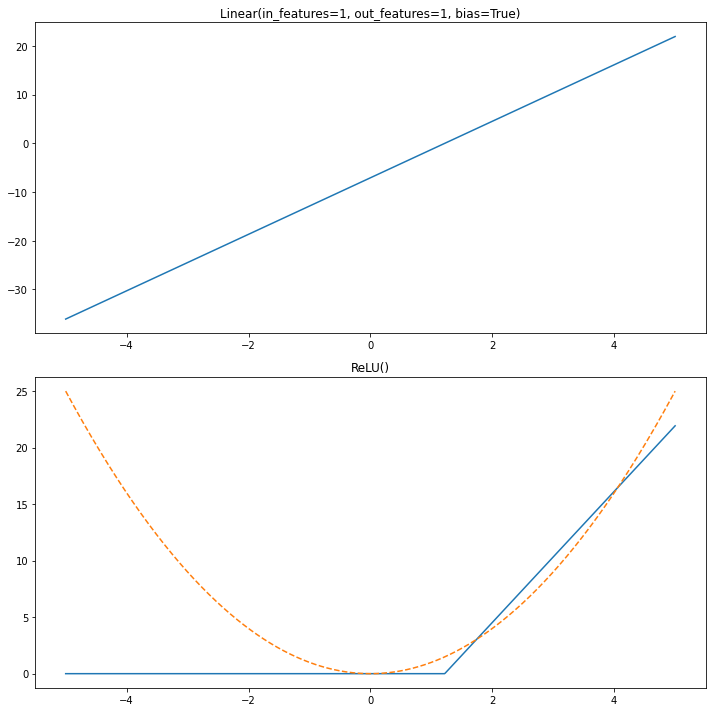

In [124]:
fig, axs = plt.subplots(len(list(relu_net.modules())[0]), figsize=(10,10))
#setup
lines = []
temp_tensor = x_torch
for i, module in enumerate(list(relu_net.modules())[0]):
        temp_tensor = module(temp_tensor)
        temp_numpy = temp_tensor.detach().numpy().squeeze()
        lines.append(axs[i].plot(x, temp_numpy)[0])
        axs[i].set_title(str(module))
axs[-1].plot(x, function(x), linestyle="dashed")
plt.tight_layout()
#define animation loop
def animate(i):
    train_loop(10,relu_net)
    for j, module in enumerate(list(relu_net.modules())[0]):
        
        global temp_tensor
        temp_tensor = module(temp_tensor)
        temp_numpy = temp_tensor.detach().numpy().squeeze()
        lines[j].set_ydata(temp_numpy)
        return lines
ani = animation.FuncAnimation(fig, animate,repeat=True, frames = 100,
                                    interval=1, blit=True, save_count=3)
writergif = animation.PillowWriter(fps=50)
ani.save('lin_relu_lin.gif',writer=writergif)

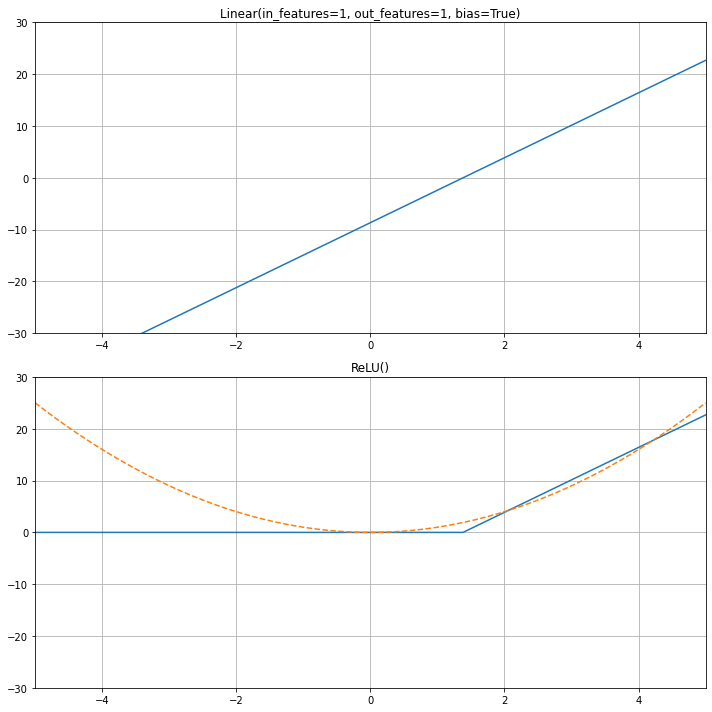

In [188]:
relu_net = torch.nn.Sequential(torch.nn.Linear(1,1),torch.nn.ReLU()) 
optimizer = torch.optim.SGD(relu_net.parameters(), lr = 0.01)
loss = torch.nn.MSELoss()
def data_gen():
    cnt = 0
    while cnt <= 5000:
        temp_tensor = x_torch
        y_arrays = []
        for i, module in enumerate(list(relu_net.modules())[0]):
            temp_tensor = module(temp_tensor)
            temp_numpy = temp_tensor.detach().numpy().squeeze()
            y_arrays.append(temp_numpy)
        train_loop(100,relu_net)
        cnt+=100
        # adapted the data generator to yield both sin and cos
        
        yield y_arrays


# create a figure with two subplots
fig, axs = plt.subplots(len(list(relu_net.modules())[0]),1,figsize = (10,10))

# intialize line objects (one in each axes)
lines = []
for  i, module in enumerate(list(relu_net.modules())[0]):
    y = module(x_torch).detach().numpy()
    line, = axs[i].plot(x,y)
    lines.append(line)
    axs[i].set_title(str(module))
    
axs[-1].plot(x,function(x), linestyle = 'dashed')

for ax in axs:
    ax.set_xlim(value_low, value_high)    
    ax.set_ylim(-30, 30)
    ax.grid()

def run(data):
    # update the data
    y_arrays = data
    
    for ax in axs:
            ax.figure.canvas.draw()

    for i in range(len(lines)):
        lines[i].set_data(x,y_arrays[i])
    
    return lines

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=1,
    repeat=True)

writergif = animation.PillowWriter(fps=30)
ani.save('lin_relu_lin_single.gif',writer=writergif)
plt.tight_layout()

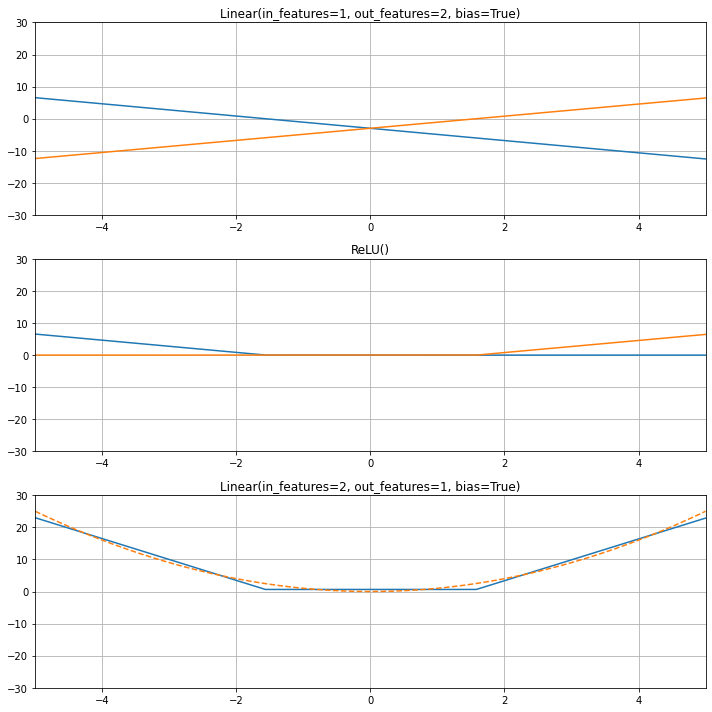

In [219]:
relu_net = torch.nn.Sequential(torch.nn.Linear(1,2),torch.nn.ReLU(),torch.nn.Linear(2,1)) 
optimizer = torch.optim.SGD(relu_net.parameters(), lr = 0.01)
loss = torch.nn.MSELoss()
def data_gen():
    cnt = 0
    while cnt <= 1000:
        temp_tensor = x_torch
        y_arrays = []
        for i, module in enumerate(list(relu_net.modules())[0]):
            temp_tensor = module(temp_tensor)
            temp_numpy = temp_tensor.detach().numpy()
            for hidden_dim in range(temp_numpy.shape[1]):
                    y_arrays.append(temp_numpy[:,hidden_dim])
        train_loop(10,relu_net)
        cnt+=10
        # adapted the data generator to yield both sin and cos
        
        yield y_arrays


# create a figure with two subplots
fig, axs = plt.subplots(len(list(relu_net.modules())[0]),1,figsize = (10,10))

# intialize line objects (one in each axes)
lines = []
x_temp = x_torch
for  i, module in enumerate(list(relu_net.modules())[0]):
    x_temp = module(x_temp)
    y = x_temp.detach().numpy()
    for hidden_dim in range(y.shape[1]): 
        line, = axs[i].plot(x,y[:,hidden_dim])
        lines.append(line)
    axs[i].set_title(str(module))
    
axs[-1].plot(x,function(x), linestyle = 'dashed')

for ax in axs:
    ax.set_xlim(value_low, value_high)    
    ax.set_ylim(-30, 30)
    ax.grid()

def run(data):
    # update the data
    y_arrays = data
    
    for ax in axs:
            ax.figure.canvas.draw()
    
    for i in range(len(lines)):
        lines[i].set_data(x,y_arrays[i])
    
    return lines

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=1,
    repeat=True)

writergif = animation.PillowWriter(fps=30)
ani.save('quadratic_1lin2_relu_2lin1.gif',writer=writergif)
plt.tight_layout()

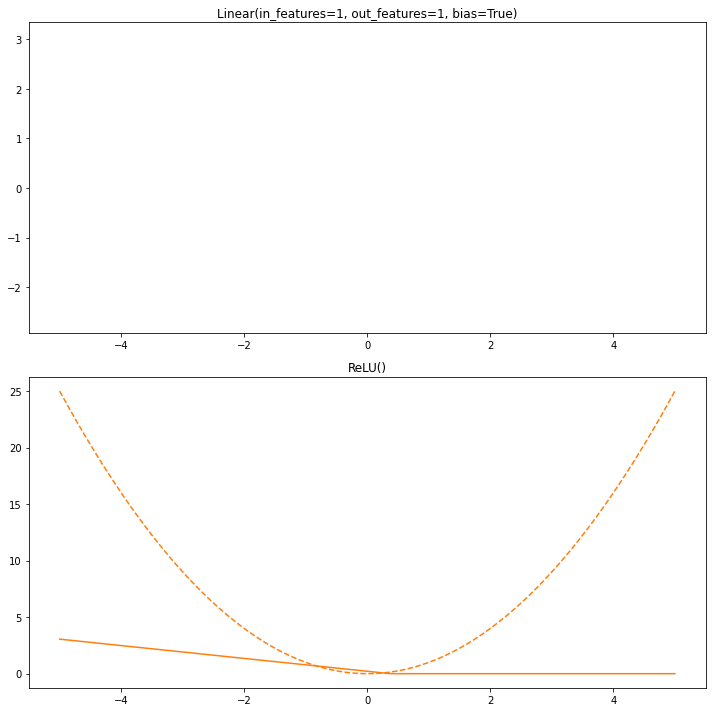

In [156]:
#implement multi hidden layer support
fig, axs = plt.subplots(len(list(relu_net.modules())[0]), figsize=(10,10))
#setup
lines = []
temp_tensor = x_torch
for i, module in enumerate(list(relu_net.modules())[0]):
        temp_tensor = module(temp_tensor)
        temp_numpy = temp_tensor.detach().numpy().squeeze()
        lines.append(axs[i].plot(x, temp_numpy))
        axs[i].set_title(str(module))

axs[-1].plot(x, function(x), linestyle="dashed")
plt.tight_layout()
#define animation loop

for i in range(100):
    train_loop(10,lin_net)
    temp_tensor =x_torch
    for j, module in enumerate(list(relu_net.modules())[0]):
        temp_tensor = module(temp_tensor)
        temp_numpy = temp_tensor.detach().numpy().squeeze()
        lines.append(axs[j].plot(x, temp_numpy))
        

ani = animation.ArtistAnimation(fig=fig, artists=lines, interval=5, repeat = True)
writergif = animation.PillowWriter(fps=0.5)
plt.tight_layout()
ani.save('lin_relu_lin_artist.gif',writer=writergif)

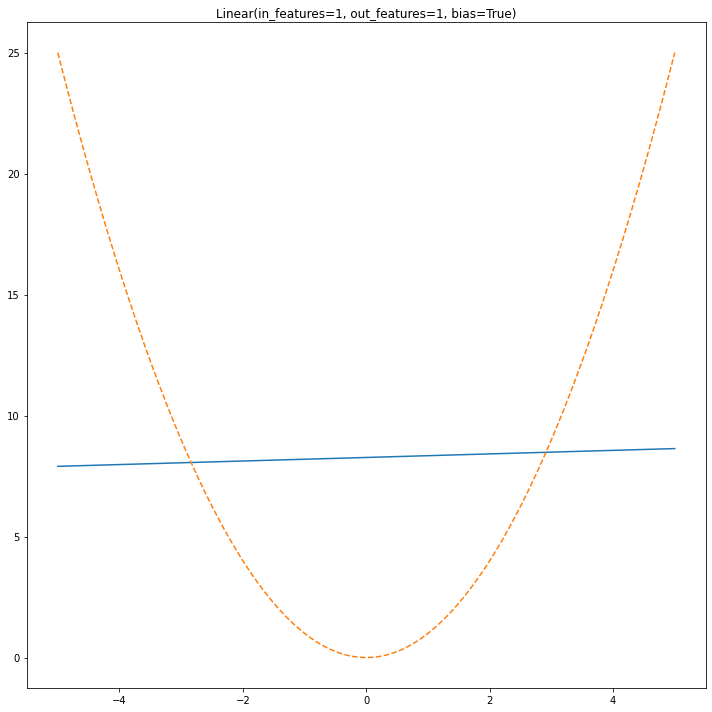

In [46]:
for _ in range(100):
    train_loop(10,lin_net)
    y = lin_net(x_torch).detach().numpy().squeeze()
    
    fig, axs = plt.subplots(1, figsize=(10,10))
    
    temp_tensor = x_torch
    
    for i, module in enumerate(list(lin_net.modules())[0]):
        temp_tensor = module(temp_tensor)
        temp_numpy = temp_tensor.detach().numpy().squeeze()
        axs.plot(x, temp_numpy)
        axs.set_title(str(module))
    
    axs.plot(x, function(x), linestyle="dashed")
    plt.tight_layout()
    
    plt.show()
    display.clear_output(wait=True)

In [216]:
relu_net[0].weight

Parameter containing:
tensor([[-1.8826],
        [ 1.8902]], requires_grad=True)

In [212]:
relu_net

ModuleAttributeError: 'ReLU' object has no attribute 'weight'